## Alpaca Automated Stock Trading

> Moving strategy from R to the native python API client

### Strategy Parameters
1. N_DAYS_AGO
    - How many days of historical data to pull each run
2. OLS_Window
    - Rolling window for alpha / beta (intercept / slope) linear fit to general market movement

In [22]:
## Warning Handling
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")
warnings.filterwarnings("ignore", message="Mean of empty slice.")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

In [57]:
N_DAYS_AGO = 365
OLS_Window = 5
CAP = 'All'
min_list_years = 5
min_volume = 400000
max_investment = 110
min_investment = 15

In [58]:
## Installing Required Packages
import sys
import time
import math
import pickle
import alpaca_trade_api as tradeapi
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

## Setting Project Folder
Project_Folder = "C://Users//" + os.getlogin() + "//documents//github//Stock-Strategy-Exploration//"

## Pulling API Keys
Keys = pd.read_csv(os.path.join('..','Data','Keys','Live API.txt'))

## Connecting to Alpaca
api = tradeapi.REST(Keys['Key ID'][0],Keys['Secret Key'][0], api_version='v2')

## API Initial Set Up
### Get Current Account Information
account = api.get_account()

## Reading In Functions
Function_Files = os.listdir('Functions')
for File in Function_Files:
    if '.py' in File:
        print(File)
        Full_File = 'Functions/'+File
        exec(open(Full_File).read())
        
def years_listed(d1):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.today()
    return abs((d2 - d1).days/365)

Group_Consolidator.py
Stock_Consolidator.py
Technical_Indicators.py


### Historical Data Pull

In [ ]:
### List of Tradable Assets
assets = api.list_assets("active")
Final_Assets = [i._raw['symbol'] for i in assets if i._raw['tradable'] & i._raw['shortable']  & i._raw['easy_to_borrow']]

## Amount of Historical Data to Pull
start_date = datetime.now() - timedelta(days=N_DAYS_AGO)
Historical_Data = defaultdict(pd.DataFrame)

## Pulling Historical Data
counter = 0
for i in tqdm(Final_Assets):
    try:        
        Company_Info = api.polygon.company(i)
        yl = years_listed(Company_Info.listdate)
        mc = Company_Info.marketcap / 1e06
        if mc < 300.:
            Cap = 'Micro'
        elif mc >= 300. and mc < 2000.:
            Cap = 'Small'
        elif mc >= 2000. and mc < 10000.:
            Cap = 'Mid'
        else:
            Cap = 'Large'
        
        if CAP != "All":
            if Cap != CAP:
                raise Exception("Skipping wrong market cap")
        if yl < min_list_years:
            raise Exception("Skipping comapny to new")
        
        TMP = api.polygon.historic_agg_v2(i, 1, 'day', _from=start_date.strftime("%Y-%m-%d"), to=datetime.now().strftime("%Y-%m-%d")).df
        
        if np.mean(TMP['close'].tail(50)) > max_investment:
            raise Exception("Price Beyond Acceptable Investment")
        if np.mean(TMP['close'].tail(50)) < min_investment:
            raise Exception("Price Beyond Acceptable Investment")
        if np.mean(TMP['volume'].tail(50)) < min_volume:
            raise Exception("Not Enough Liquidity")
        
        TMP['market_cap'] = Cap    
        TMP['date'] = TMP.index
        TMP['sector'] = Company_Info.sector
        TMP['industry'] = Company_Info.industry
        Historical_Data[i] = TMP 
    except:
        counter += 1

print(str(counter) + " Symbols Failed During Data Pull")
## Adding Stock Attribute Before Combining
for s in Historical_Data:
    Historical_Data[s].insert(0, 'stock', [s]*len(Historical_Data[s]))

## Combining Data To Single Data Frame
Combined_Data = pd.concat(Historical_Data.values())  
Combined_Data = Combined_Data[Combined_Data['sector'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['sector'])]
Combined_Data = Combined_Data[Combined_Data['industry'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['industry'])]

## Saving Data
pickle.dump(Combined_Data, open(Project_Folder + "Data//Historical_Data.p" , "wb" ) )

### Exploring Total Market Performance

In [27]:
## Loading Stored Data
Combined_Data = pickle.load(open(Project_Folder + "Data//Historical_Data.p" , "rb" ))
Combined_Data = Combined_Data.drop_duplicates()

Total_Market = Stock_Consolidator(Combined_Data)
Total_Market = Total_Market.loc[Total_Market.RSI > 0,:]
Total_Market.tail(5)

,close,volume,count,close_diff,close_return,volume_diff,sma,RSI,MACD
date,,,,,,,,,
2020-09-28 00:00:00-04:00,47.116890,1.980872e+06,864.0,0.019354,0.017619,0.034789,46.235296,33.660015,-0.141731
2020-09-29 00:00:00-04:00,46.777305,3.157513e+06,864.0,-0.007207,0.003227,0.594001,46.265391,38.274685,-0.096923
2020-09-30 00:00:00-04:00,47.028187,4.039966e+06,864.0,0.005363,0.031755,0.279477,46.554878,38.810540,-0.045962
2020-10-01 00:00:00-04:00,47.491664,3.699468e+06,864.0,0.009855,0.040806,-0.084282,46.927268,37.495825,0.019856
2020-10-02 00:00:00-04:00,47.738934,3.485542e+06,863.0,0.005207,0.032812,-0.057826,47.230596,40.147128,0.077693


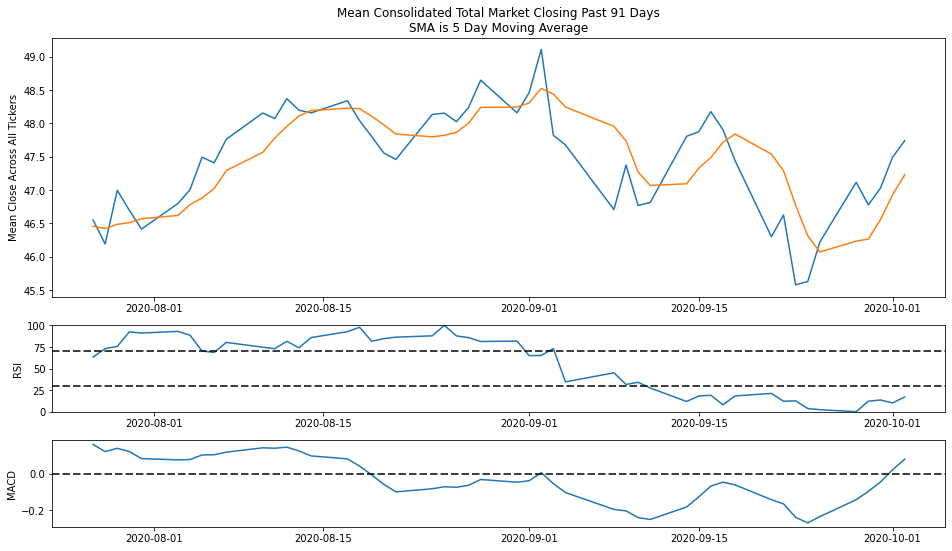

In [30]:
%matplotlib inline
Plot_Data = Total_Market
Plot_Data['RSI'] = ((Plot_Data['RSI'] -  np.min(Plot_Data['RSI'])) / (np.max(Plot_Data['RSI']) - np.min(Plot_Data['RSI'])))*100


Plot_Data['date'] = Plot_Data.index.get_level_values('date')
Plot_Data = Plot_Data.reset_index(drop = True)
x = Plot_Data['date']

fig, axs = plt.subplots(3,1,gridspec_kw={'height_ratios':[3,1,1]})
axs[0].plot(x,Plot_Data['close'])
axs[0].plot(x,Plot_Data['sma'])
axs[1].plot(x,Plot_Data['RSI'])
axs[1].axhline(y = 70,c = 'black',dashes = (5,2))
axs[1].axhline(y = 30,c = 'black',dashes = (5,2))
axs[2].plot(x,Plot_Data['MACD'])
axs[2].axhline(y = 0,c = 'black',dashes = (5,2))

axs[0].set(title = "Mean Consolidated Total Market Closing Past "+ str(N_DAYS_AGO) +" Days\nSMA is " + str(OLS_Window) +" Day Moving Average",
      ylabel = "Mean Close Across All Tickers",
      xlabel = "")
axs[1].set(ylabel = "RSI",
      xlabel = "",
      ylim = [0,100])
axs[2].set(ylabel = "MACD",
      xlabel = "")
fig.set_size_inches(16,9)

## Digging Into A Sector Ranking

In [36]:
Sectors = list(Combined_Data['sector'].unique())
Sector_Summary = Group_Consolidator(Combined_Data = Combined_Data,
                                    groups = Sectors,
                                    column = 'sector',
                                    min_macd = 0,
                                    min_alpha = 0,
                                    min_risk_ratio = 1
)
Sector_Summary

,stock_count,last_period_return,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta
sector,,,,,,,,,,
Utilities,39,0.034709,51.569359,1.079746,0.002708,49.041424,0.169883,0.005725,0.228,0.318431
Healthcare,106,0.022532,50.778736,1.101232,0.000246,59.336699,0.083844,0.001947,0.614,0.566376


## Diving Further Into Individual Idustries

In [37]:
Top_Sector = Combined_Data[Combined_Data['sector'].isin(Sector_Summary.index.values)]
Industries = list(Top_Sector['industry'].unique())
Industry_Summary = Group_Consolidator(Combined_Data = Top_Sector,
                                      groups = Industries,
                                      column = 'industry',
                                      max_alpha_p = 0.50,
                                      min_alpha = 0,
                                      min_macd = 0
                                     )
Industry_Summary

,stock_count,last_period_return,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta
industry,,,,,,,,,,
Medical Diagnostics & Research,11,0.081188,54.888364,1.111731,0.006574,59.361278,0.559411,0.014705,0.130,0.407035
Utilities - Independent Power Producers,4,0.064547,50.254500,1.351610,0.004352,56.150751,0.357341,0.011935,0.048,0.292709
Utilities - Regulated,35,0.031504,51.719629,1.079814,0.002533,45.237458,0.148459,0.005048,0.296,0.321532
Medical Instruments & Equipment,11,0.026815,62.737273,1.237620,0.000932,61.353388,0.108299,0.001975,0.476,0.677275


## Diving Into The Individual Stocks

In [38]:
Top_Industry = Top_Sector[Top_Sector['industry'].isin(Industry_Summary.index.values)]
Stocks = list(Top_Industry['stock'].unique())
Stock_Summary = Group_Consolidator(Combined_Data = Top_Industry,
                                   groups = Stocks,
                                   column = 'stock',
                                   max_alpha_p = 0.25,
                                   min_alpha = 0,
                                   min_macd = 0,
                                   max_rsi = 70
)
Stock_Summary. \
    sort_values(by = ['rsi'],ascending = [1])

,stock_count,last_period_return,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta
stock,,,,,,,,,,
OGE,1,0.037639,30.116,1.252865,0.002022,28.345965,0.104894,0.005653,0.044,0.310777
NGG,1,0.067304,57.488,1.413306,0.006813,41.098866,0.386272,0.019198,0.138,-0.876576
ES,1,0.060351,84.342,0.993098,0.003646,44.232954,0.403551,0.010622,0.148,0.318400
ED,1,0.055059,77.982,0.648405,0.005245,51.034295,0.449213,0.009808,0.022,0.267527
PEG,1,0.045537,55.016,1.713301,0.004701,52.210541,0.352553,0.009353,0.094,0.050971
ORA,1,0.053649,59.372,0.752123,0.002749,58.892522,0.346504,0.009893,0.204,0.243996
CDNA,1,0.194173,38.534,1.385385,0.015023,64.149520,0.501567,0.032048,0.242,1.315579
QGEN,1,0.026607,52.206,0.303159,0.003291,65.667278,0.198125,0.007993,0.100,-0.448693


In [ ]:
Stock_Data = pd.DataFrame()
Stocks = list(Stock_Summary.index)
weights = np.ones(len(Stocks))/len(Stocks)

for Stock in Stocks:
    Stock_Data[Stock] = Top_Industry['close'][Top_Industry.stock == Stock]
    
returns = Stock_Data.pct_change()
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

port_volatility = np.sqrt(port_variance)
port_volatility

portfolioSimpleAnnualReturn = np.sum(returns.mean()*weights) * 252
portfolioSimpleAnnualReturn

percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2)*100)+'%'
print("Expected annual return : "+ percent_ret)
print('Annual volatility/standard deviation/risk : '+percent_vols)
print('Annual variance : '+percent_var)

mu = expected_returns.mean_historical_return(Stock_Data)#returns.mean() * 252
S = risk_models.sample_cov(Stock_Data) #Get the sample covariance matrix

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe() #Maximize the Sharpe ratio, and get the raw weights
cleaned_weights = ef.clean_weights() 
print(cleaned_weights) #Note the weights may have some rounding error, meaning they may not add up exactly to 1 but should be close
Optimized_Portfolio = ef.portfolio_performance(verbose=True)